## 数据分析时间序列项目 - 沪市指数价格走势预测

项目分析目标：
* 分析上证指数历史开盘价格最新交易数据，预测未来10个月平均开盘价格走势。并验证预测价格与实际开盘价格趋势是否相吻合，并指导到实际业务中。

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima_model import ARMA
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = 'SimHei'

### 数据导入

In [2]:
df = pd.read_csv('shanghai_1990-12-19_to_2019-6-28.csv')
df.head()

,Timestamp,Price
0,2019/6/28,2992.2426
1,2019/6/27,2982.6125
2,2019/6/26,2964.6153
3,2019/6/25,3004.9095
4,2019/6/24,3004.2891


### 数据探索

In [3]:
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

In [6]:
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
df_month.head()

,Price
Timestamp,
1990-12-31,116.285556
1991-01-31,132.367273
1991-02-28,131.877778
1991-03-31,126.002381
1991-04-30,118.459091


### 按照天、月、季度、年显示上证A股指数走势

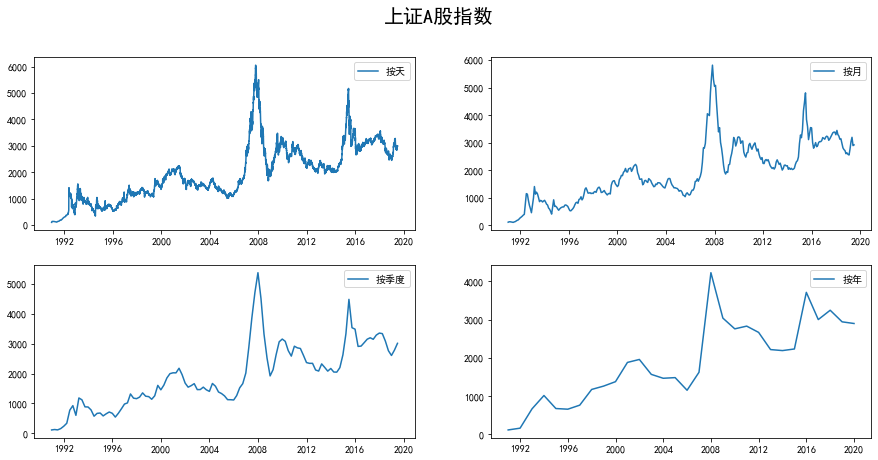

In [29]:
fig=plt.figure(figsize=[15,7])
plt.suptitle('上证A股指数',fontsize = 20)
plt.subplot(2,2,1)
plt.plot(df.Price,'-',label="按天")
plt.legend()
plt.subplot(2,2,2)
plt.plot(df_month.Price,'-',label="按月")
plt.legend()
plt.subplot(2,2,3)
plt.plot(df_Q.Price,'-',label="按季度")
plt.legend()
plt.subplot(2,2,4)
plt.plot(df_year,'-',label="按年")
plt.legend()
plt.show()

### 建立ARMA模型

#### 根据上证指数历史走势，设置模型参数范围，遍历查找最优模型

In [14]:
ps = range(0,7)
qs = range(0,7)
order_number = product(ps,qs)
order_number_list = list(order_number)

In [15]:
results = []
best_aic = float("inf")
for order in order_number_list:
    try:
        model = ARMA(df_month.Price,order=(order[0],order[1])).fit()
    except:
        print("阶数错误",order)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_order = order
    results.append([order,model.aic])

阶数错误 (0, 2)
阶数错误 (0, 3)
阶数错误 (0, 4)
阶数错误 (0, 5)
阶数错误 (0, 6)
阶数错误 (4, 6)
阶数错误 (5, 6)
阶数错误 (6, 6)


#### 输出最优模型

In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['order_number','aic']
print('最佳模型:',best_model.summary())

最佳模型:                               ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  343
Model:                     ARMA(5, 4)   Log Likelihood               -2224.120
Method:                       css-mle   S.D. of innovations            157.280
Date:                Mon, 27 Apr 2020   AIC                           4470.240
Time:                        16:48:12   BIC                           4512.455
Sample:                    12-31-1990   HQIC                          4487.056
                         - 06-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2211.2464    627.460      3.524      0.000     981.448    3441.045
ar.L1.Price     2.5564      0.103     24.881      0.000       2.355       2.758
ar.L2.Price    -2.8217      0.222    -12.7

### 预测上证A股未来10个月内的价格走势

In [21]:
df_month_value = df_month[['Price']]

date_list = [datetime(2019,7,31),datetime(2019,8,31),datetime(2019,9,30),
             datetime(2019,10,31),datetime(2019,11,30),datetime(2019,12,31),
             datetime(2020, 1, 31), datetime(2020, 2, 29),datetime(2020, 3, 31),datetime(2020, 4, 30)]

pred_future = pd.DataFrame(index=date_list,columns=df_month.columns)
df_month_value = pd.concat([df_month_value,pred_future])
df_month_value['forecast'] = best_model.predict(start=0,end=352)

In [27]:
df_month_value.rename(columns={'Price':'实际价格','forecast':'预测价格'},inplace=True)
df_month_value.head()

,实际价格,预测价格
1990-12-31,116.285556,2211.246438
1991-01-31,132.367273,140.111247
1991-02-28,131.877778,168.794386
1991-03-31,126.002381,162.453100
1991-04-30,118.459091,156.157161


### 绘制上证A股(月)平均开盘实际价格和预测价格指数走势图

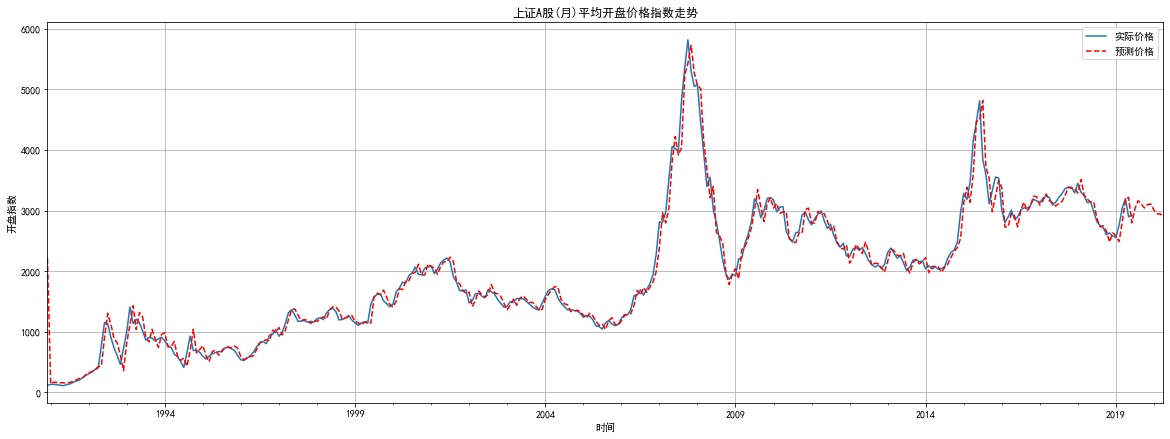

In [31]:
plt.figure(figsize=(20,7))
df_month_value["实际价格"].plot(label='实际价格')
df_month_value["预测价格"].plot(color='r',ls = '--',label="预测价格")
plt.grid(True)
plt.legend()
plt.title("上证A股(月)平均开盘价格指数走势")
plt.xlabel("时间")
plt.ylabel("开盘指数")
plt.show()

### 对预测的未来10月价格走势和真实价格走势做对比,观察模型预测效果

In [38]:
df1 = pd.read_csv("shanghai_1990-12-19_to_2020-4-24.csv")
df1.Timestamp = pd.to_datetime(df1.Timestamp)
df1.index = df1.Timestamp
df1_month = df1.resample('M').mean()

In [47]:
df1_month.loc['2019-07-31':'2020-4-30']["Price"]

Timestamp
2019-07-31    2950.249100
2019-08-31    2844.336023
2019-09-30    2981.626915
2019-10-31    2954.994633
2019-11-30    2926.116857
2019-12-31    2954.663082
2020-01-31    3082.987650
2020-02-29    2907.666290
2020-03-31    2852.835282
2020-04-30    2807.380335
Freq: M, Name: Price, dtype: float64

In [45]:
df_month_value.loc['2019-07-31':'2020-4-30']["预测价格"]

2019-07-31    3030.191582
2019-08-31    3162.639128
2019-09-30    3104.769371
2019-10-31    3042.460404
2019-11-30    3100.073905
2019-12-31    3106.061290
2020-01-31    3003.541780
2020-02-29    2943.471993
2020-03-31    2944.025033
2020-04-30    2890.933019
Name: 预测价格, dtype: float64

#### 验证模型有效性: 绘制未来10月实际与预测价格走势对比图

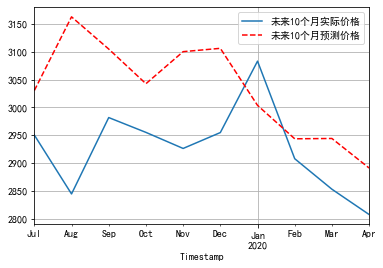

In [61]:
df1_month.loc['2019-07-31':'2020-4-30']["Price"].plot(label='未来10个月实际价格')
df_month_value.loc['2019-07-31':'2020-4-30']["预测价格"].plot(color='r',ls = '--',label="未来10个月预测价格")
plt.grid(True)
plt.legend()
plt.show()

### 项目分析总结
* 在对上证指数历史数据按照天、月、季度、年四个维度进行价格走势探索时,发现按月划分的价格走势和按天划分的价格走势差别不大,于是我对原始数据进行了降维,按月为粒度进行了统计,相比较按天会产生较大波动的同时按月也能体现出A股指数价格的趋势,数据量还降到了 1/30,同时也缩减了ARMA模型的训练时间，大大提升了效率.
* 通过开盘价格走势对比图可以看出在未来10个月中,预测价格与实际价格在前三个月误差较大,后面7个月走势基本一致,虽然整体预测价格偏高,但最终与实际开盘价格相吻合,来到了2800元左右的价格,验证了时间序列ARMA预测模型的有效性.